Copyright by Dr. Carl-Magnus Svensson
Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge
https://www.leibniz-hki.de/en/applied-systems-biology.html
HKI-Center for Systems Biology of Infection
Leibniz Institute for Natural Product Research and Infection Biology -
Hans Knöll Insitute (HKI)
Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [5]:
from tqdm import tqdm
import json
import os
import glob
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
from pathlib import Path
from numba import jit
import scipy.stats as sstats
from Peroxisome_HMM import viterbi, Baum_Welch, convert_to_cartesian, convert_to_planar, flatten_list
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
from numba import jit
import scipy.stats as sstats

@jit(nopython=True)
def lognorm_pdf(x, mu, sigma):
    ''' PDF of the log-normal distribution.'''
    out = 1.0/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(sigma**2))
    
    return out

In [3]:
@jit(nopython=True)
def norm_pdf(x, mu, sigma):

    out = 1.0/(sigma*np.sqrt(2*np.pi))*np.exp(-((x-mu)**2)/(sigma**2))

    return out

In [4]:
@jit(nopython=True)
def p_o_G_s(o, s, mu_l, sigma_l, sigma_alpha_2):
    p_l = lognorm_pdf(o[0], mu_l[s], sigma_l[s]) 
    if s == 0:
        p_alpha = 1/(2*np.pi)
    else:
        p_alpha = norm_pdf(o[1], 0.0, sigma_alpha_2)

    p_o_G_s = p_l*p_alpha
    
    if p_o_G_s < 10**(-20):
        p_o_G_s = 10**(-20)
    
    return p_o_G_s

In [5]:
@jit(nopython=True)
def p_olog_G_s(o, s, mu_l, sigma_l, sigma_alpha_2):
    p_l = norm_pdf(o[0], mu_l[s], sigma_l[s]) 

    if s == 0:
        p_alpha = 1/(2*np.pi)
    else:
        p_alpha = norm_pdf(o[1], 0.0, sigma_alpha_2)

    p_o_G_s = p_l*p_alpha
    if p_o_G_s < 10**(-20):
        p_o_G_s = 10**(-20)
    return p_o_G_s

In [6]:
@jit(nopython=True)
def viterbi(T, pi, mu_l, sigma_l, sigma_alpha_2, O):
    """Viterbi algorithm for solving the uncovering problem

    Notebook: C5/C5S3_Viterbi.ipynb

    Args:
        T (np.ndarray): State transition probability matrix of dimension K x K
        pi (np.ndarray): Initial state distribution  of dimension K
        O (np.ndarray): Observation sequence of length N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        D (np.ndarray): Accumulated probability matrix
        E (np.ndarray): Backtracking matrix
    """
    K = T.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence

    # Initialize D and E matrices
    D = np.zeros((K, N)).astype(np.float64)
    E = np.zeros((K, N-1)).astype(np.int32)
    D[:, 0] = pi #np.multiply(C, B[:, O[0]])

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(K):
            temp_product = np.multiply(T[:, i], D[:, n-1])
            D[i, n] = np.max(temp_product) * p_o_G_s(O[n], i, mu_l, sigma_l, sigma_alpha_2)
            E[i, n-1] = np.argmax(temp_product)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    return S_opt, D, E

In [7]:
def convert_to_cartesian(o):
    X = np.zeros(o.shape, dtype=float)
    X[:,1] = np.cumsum(o[:,1])
    X[:,0] = np.cumsum(o[:,0]*np.cos(X[:,1]))
    X[:,1] = np.cumsum(o[:,0]*np.sin(X[:,1]))
    
    return X

In [8]:
def convert_to_planar(X, dt=1.0):
    X_diff = np.diff(X, axis=0)
    l = np.sqrt(X_diff[:,0]**2+X_diff[:,1]**2)/dt + np.random. uniform(0.0, 0.000001)
    correct_idx = (l>0.0).nonzero()
    gamma = np.arctan2(X_diff[:,1],X_diff[:,0])
    alpha = np.diff(gamma)
    alpha[alpha>np.pi] = alpha[alpha>np.pi] - 2*np.pi
    alpha[alpha<-np.pi] = alpha[alpha<-np.pi] + 2*np.pi

    return l[1:], alpha[:-2]

In [2]:
@jit(nopython=True)
def adaptable_diff(v, step=1):
    '''Calculate the difference vector with adjustable step.
    
       This implementation differs from that standard implementation of numpy.diff by being able to adjust the step in the difference.
       Numpy's implementation sets d[i]=v[i+1]-v[i], while this one takes d[i]=v[i+step]-v[i]. 
       
       TODO: Implement recursiveness, padding and compatibility with multidimentionsal vectors.'''
    if v.shape[0]-step > 0:
        d = np.zeros(v.shape[0]-step).astype(v.dtype)
        for ii in range(d.shape[0]):
            d[ii] = v[ii+step] - v[ii]
    else:
        return np.array([0]).astype(v.dtype)
         
    return d

In [6]:
def filter_tracks(tables, norm=False, new_data=False):
    straight_tracks = {}
    straight_tracks['total tracks'] = []
    all_tracks = {}
    all_tracks['total tracks'] = []
    for table in tqdm(tables[:]):
        #print(table)
        d = table[:]
        #if Path(d+"/Tracks").exists():
        #    fileList = glob.glob(d+"/Tracks/*.png", recursive=False)
        #    for im in fileList:
        #        os.remove(im)
        #Path(d+"/Tracks").mkdir(parents=True, exist_ok=True)
        #print(d)
        key_counter = 0
        #tracks = pd.read_csv(d + 'Track_Data.xls', sep='\t')
        if norm:
            try:
                if len(glob.glob(d + '/*.xls'))>0:
                    tracks = pd.read_csv(d + '/' + d[d.rfind('/')+1:] + '.xls', sep='\t')
                elif len(glob.glob(d + '/*.xlsx'))>0: 
                    tracks = pd.read_csv(d + '/' + d[d.rfind('/')+1:] + '.xlsx', sep='\t')
                else:
                    tracks = pd.read_csv(d + '/' + d[d.rfind('/')+1:] + '.csv', sep=',')
                with open(d + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
                    params = json.load(read_file)

            except:
                print('Could not read params and/or track file for %s'%d)
                continue
        elif new_data:
            try:
                track_file = d + d[d.rfind('/'):]+'.xls'
                tracks = pd.read_csv(track_file, sep='\t')
                with open(d + '/' +"fitted_params_mu_sig_fixed2.json", "r") as read_file:
                    params = json.load(read_file)
            except:
                print('Could not read params and/or track file for %s'%track_file)
                continue
        else:   
            try:
                tracks = pd.read_csv(d + '/Track_Data.xls', sep='\t')
                with open(d + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
                    params = json.load(read_file)
            except:
                print('Could not read params and/or track file for %s'%d)
                continue
            try:
                with open(d + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
                    params = json.load(read_file)
            except:
                continue
        straight_tracks[d] = {}
        all_tracks[d] = []

        total_tracks = 0
        for dist in range(1,10):
            straight_tracks[d][dist] = []
        for key in params.keys(): 
            track = int(params[key]['track_id'])
            track0 = tracks.loc[tracks['TRACK_ID']==track]

            pi_tot = np.array(params[key]['pi'])
            mu_tot = np.array(params[key]['mu_l'])
            sigma_tot = np.array(params[key]['sigma_l'])
            T_tot = np.array(params[key]['T'])

            X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
            l, alpha = convert_to_planar(X)
            o = np.array([l[1:-1], alpha]).T
            if o.shape[0] > 50 and np.isfinite(T_tot).all() and np.isfinite(pi_tot).all() and np.isfinite(mu_tot).all() and np.isfinite(sigma_tot).all():
                total_tracks += 1
                s_est, D, E = viterbi(T_tot, pi_tot, mu_tot, sigma_tot, float(params['0']['sigma_alpha_2']), o)
                s1_idx = s_est.nonzero()[0]
                all_tracks[d].append(key)
                for dist in range(1,10):
                    if s1_idx.shape[0]>(dist-1):
                        d_v = adaptable_diff(s1_idx, dist)
                        if dist in d_v:
                            straight_tracks[d][dist].append(key)

        straight_tracks['total tracks'].append(total_tracks)
        all_tracks['total tracks'].append(total_tracks)     
        
    return straight_tracks, all_tracks

### Load all tracks and parameters

In [7]:
with open('/data/Peroxisome tracks/HEK WT/cell_list.txt') as f_norm:
    norm_tables = f_norm.read().splitlines()

straight_norm_tracks, all_norm_tracks = filter_tracks(norm_tables, norm=True)

100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


In [67]:
l = np.array(all_norm_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
for ii, key in enumerate(list(all_norm_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    T_av_tmp =[]
    for track in all_norm_tracks[key]:
        mu_tmp.append(params[str(track)]['mu_l'])
        sigma_tmp.append(params[str(track)]['sigma_l'])
        pi_tmp.append(params[str(track)]['pi'])
        T_tmp.append(params[str(track)]['T'])
        
    T_average = np.mean(np.array(T_tmp), axis=0)    
    pi_average = np.mean(np.array(pi_tmp), axis=0)
    #for dist in range(1,10):
    #    PS_tmp.append(len(straight_norm_tracks[key][dist])/l[ii])
    #   
   # 
    #    T_average = np.mean(np.array(T_tmp), axis=0)
    #    T_av_tmp.append(T_average)
    T_per_cell.append(T_average)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_average))
    T.append(np.copy(T_tmp))
    
mu_l_norm_all = np.array(mu_l)   
sigma_l_norm_all = np.array(sigma_l)
pi_norm_all = np.array(pi)
T_norm_all = np.array(T)
T_per_cell_norm_all= np.array(T_per_cell)
print(len(l))
print(np.sum(l))

190
312873


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dty

In [13]:
l = np.array(straight_norm_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
PS_norm = []
for ii, key in enumerate(list(straight_norm_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    PS_tmp = []
    T_av_tmp =[]
    for dist in range(1,10):
        PS_tmp.append(len(straight_norm_tracks[key][dist])/l[ii])
        for track in straight_norm_tracks[key][dist]:
            mu_tmp.append(params[str(track)]['mu_l'])
            sigma_tmp.append(params[str(track)]['sigma_l'])
            pi_tmp.append(params[str(track)]['pi'])
            T_tmp.append(params[str(track)]['T'])
    
        T_average = np.mean(np.array(T_tmp), axis=0)
        T_av_tmp.append(T_average)
    T_per_cell.append(T_av_tmp)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_tmp))
    T.append(np.copy(T_tmp))
    PS_norm.append(np.copy(PS_tmp))
    
mu_l_norm = np.array(mu_l)   
sigma_l_norm = np.array(sigma_l)
pi_norm = np.array(pi)
T_norm = np.array(T)
PS_norm = np.array(PS_norm)
T_per_cell_norm = np.array(T_per_cell)
print(len(l))
print(np.sum(l))

190
312873


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

In [14]:
print(np.array(T_per_cell_norm).shape)

(190, 9, 2, 2)


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff9fba2fd50>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff9fba60a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ffa06204550>,
 'medians': [<matplotlib.lines.Line2D at 0x7ffa05ecd050>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff9f84978d0>,
 'means': []}

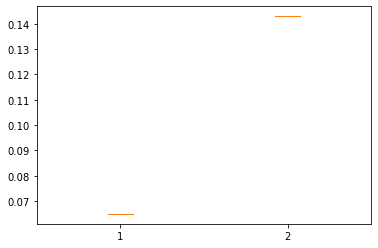

In [15]:
plt.boxplot(np.exp(mu_l_norm[0]+sigma_l_norm[0]/2))

In [16]:
np.sum(l)

312873

In [17]:
with open('/data/Peroxisome tracks/noc/cell_list.txt') as f_norm:
    noc_tables = f_norm.read().splitlines()

straight_noc_tracks, all_noc_tracks = filter_tracks(noc_tables)
#straight_noc_tracks = {}
#straight_noc_tracks['total tracks'] = []
#all_noc_tracks = {}
#all_noc_tracks['total tracks'] = []

#for table in tqdm(noc_tables[:]):
#    #print(table)
#    d = table[:]
#    if Path(d+"/Tracks").exists():
#        fileList = glob.glob(d+"Tracks/*.png", recursive=False)
#        for im in fileList:
#            os.remove(im)
    #print(d)
#    key_counter = 0
#    try:
#        tracks = pd.read_csv(d + '/Track_Data.xls', sep='\t')
#        with open(d + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
#            params = json.load(read_file)
#    except:
#        print('Could not read params and/or track file for %s'%d)
#        continue
    #tracks = pd.read_csv(d + '/Track_Data.xls', sep='\t')
    #with open(d + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
    #    params = json.load(read_file)
#    straight_noc_tracks[d] = {}
#    all_noc_tracks[d] = []
    
#    total_tracks = 0
#    for dist in range(1,10):
#        straight_noc_tracks[d][dist] = []
#    for key in params.keys():
#        
#        track = int(params[key]['track_id'])
#        track0 = tracks.loc[tracks['TRACK_ID']==track]
# 
#        pi_tot = np.array(params[key]['pi'])
#        mu_tot = np.array(params[key]['mu_l'])
#        sigma_tot = np.array(params[key]['sigma_l'])
#        T_tot = np.array(params[key]['T'])
#                         
#        X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
#        l, alpha = convert_to_planar(X)
#        o = np.array([l[1:-1], alpha]).T
#        if o.shape[0] > 50 and np.isfinite(T_tot).all() and np.isfinite(pi_tot).all() and np.isfinite(mu_tot).all() and np.isfinite(sigma_tot).all():
#            total_tracks += 1
#            Path(d+"Tracks").mkdir(parents=True, exist_ok=True)
#            s_est, D, E = viterbi(T_tot, pi_tot, mu_tot, sigma_tot, float(params['0']['sigma_alpha_2']), o)
#            s1_idx = s_est.nonzero()[0]
#            all_noc_tracks[d].append(key)
#            for dist in range(1,10):
#                #straight_norm_tracks[d][dist] = []
                #f o.shape[0] > (dist-1) and np.isfinite(T_tot).all() and np.isfinite(pi_tot).all() and np.isfinite(mu_tot).all() and np.isfinite(sigma_tot).all():
#                if s1_idx.shape[0]>(dist-1):
#                    d_v = adaptable_diff(s1_idx, dist)
#                    if dist in d_v:
                        #if params[key]['T'][1][1] > 0.4:
#                        straight_noc_tracks[d][dist].append(key)
                        #if dist == 6:
                        #    s_1_idx = (s_est==0)
                        #    s_2_idx = (s_est==1)
                            #print(X.shape)
                        #    for ii in range(X.shape[0]-5):
                        #        if s_est[ii+1] == 0:
                        #            plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='blue')
                        #        else:
                        #            plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='red')
                        #    plt.savefig(d+"Tracks/"+str(params[key]['track_id']))
                        #    plt.close('all')
                    #for ii in range(X.shape[0]-5):
                    #    if s_est[ii+1] == 0:
                    #        plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='blue')
                    #    else:
                    #        plt.plot(X[ii+1:ii+3,0], X[ii+1:ii+3,1], c='red')
                    #plt.savefig(d+"Tracks/"+str(params[key]['track_id']))
                    #plt.close('all')
#    straight_noc_tracks['total tracks'].append(total_tracks)
#    all_noc_tracks['total tracks'].append(total_tracks)

100%|██████████| 130/130 [24:49<00:00, 11.46s/it]


In [66]:
l = np.array(all_noc_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
for ii, key in enumerate(list(all_noc_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    T_av_tmp =[]
    for track in all_noc_tracks[key]:
        mu_tmp.append(params[str(track)]['mu_l'])
        sigma_tmp.append(params[str(track)]['sigma_l'])
        pi_tmp.append(params[str(track)]['pi'])
        T_tmp.append(params[str(track)]['T'])
    T_average = np.mean(np.array(T_tmp), axis=0)    
    pi_average = np.mean(np.array(pi_tmp), axis=0)
    #for dist in range(1,10):
    #    PS_tmp.append(len(straight_norm_tracks[key][dist])/l[ii])
    #   
   # 
    #    T_average = np.mean(np.array(T_tmp), axis=0)
    #    T_av_tmp.append(T_average)
    T_per_cell.append(T_average)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_average))
    T.append(np.copy(T_tmp))
    
mu_l_noc_all = np.array(mu_l)   
sigma_l_noc_all = np.array(sigma_l)
pi_noc_all = np.array(pi)
T_noc_all = np.array(T)
T_per_cell_noc_all= np.array(T_per_cell)
print(len(l))
print(np.sum(l))

130
1422039


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dty

In [19]:
l = np.array(straight_noc_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
PS_noc = []
T_per_cell = []
for ii, key in enumerate(list(straight_noc_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    PS_tmp = []
    T_av_tmp = []
    for dist in range(1,10):
        PS_tmp.append(len(straight_noc_tracks[key][dist])/l[ii])
        for track in straight_noc_tracks[key][dist]:
            mu_tmp.append(params[str(track)]['mu_l'])
            sigma_tmp.append(params[str(track)]['sigma_l'])
            pi_tmp.append(params[str(track)]['pi'])
            T_tmp.append(params[str(track)]['T'])
        T_average = np.mean(np.array(T_tmp), axis=0)
        T_av_tmp.append(T_average)
    T_per_cell.append(T_av_tmp)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_tmp))
    T.append(np.copy(T_tmp))
    PS_noc.append(np.copy(PS_tmp))
    
mu_l_noc = np.array(mu_l)   
sigma_l_noc = np.array(sigma_l)
pi_noc = np.array(pi)
T_noc = np.array(T)
PS_noc = np.array(PS_noc)
T_per_cell_noc = np.array(T_per_cell)
print(np.mean(PS_noc,axis=0))
print(len(l))
print(l)

[3.08088493e-01 1.23326298e-01 3.86035582e-02 1.14513731e-02
 3.51600828e-03 1.17401372e-03 5.43504506e-04 2.86377298e-04
 2.15966869e-04]
130
[ 6275 10462  6944 12502 10790 12097  5950 14305 11153  5172  6322 14414
 10266  5929  7818 24036 10499 13627 10503 10635  8626 19713 12938 21663
  6613 15662  3724 13035  7770  9676  9441 31677  2309  3235 16402  4985
  6637 13291  8016 12976 14361 12897  9185  5930 14442 11876 24513  5695
 15976  6883 17115 13853 15207 11085  9217 12830  9512  4997  9329 19115
  9577  6598  7293  8194 12723 11832  4458 10349  9951 18468 14516  8973
  3354 13466 12446  3218  4658  3376 12731  8882 13659 11774  7779  8082
 10891  5075  2150  7055  8667 14140 13731  3359  3076 15704  6028  7600
 22441 12454 22638  9994 17184 17559 11968 14094  5119 25189  9065  3838
  5724 13021  6914 14043 14097  6194 13103 21909 12100 10399  8906 15186
 16137  8069  9684  7022 11166 18966  2010 15084  2747 12076]


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff9dd131c50>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff9f9253a50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff9dd131450>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff9ce401290>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff9ce40df50>,
 'means': []}

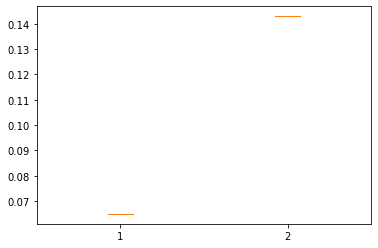

In [20]:
plt.boxplot(np.exp(mu_l_noc[0]+sigma_l_noc[0]/2))

In [21]:
with open('/data/Peroxisome tracks/ko pex14/cell_list.txt') as f_norm:
    kop_tables = f_norm.read().splitlines()
    
straight_kop_tracks, all_kop_tracks = filter_tracks(kop_tables)
                    

  2%|▏         | 3/134 [00:01<01:08,  1.92it/s]

Could not read params and/or track file for /data/Peroxisome tracks/ko pex14/20180621_HEK KO PEX14_pJK26_GFP90ms_Triggered_2_5 cell3.csv_Ordner


 51%|█████▏    | 69/134 [00:41<00:27,  2.37it/s]

Could not read params and/or track file for /data/Peroxisome tracks/ko pex14/20180427_KOPX14_pJK26_GFP90ms_Triggered_2_4cell3.xls_Ordner


 71%|███████   | 95/134 [00:58<00:24,  1.57it/s]

Could not read params and/or track file for /data/Peroxisome tracks/ko pex14/20180427_KOPEX14_pJK26_GFP90ms_Triggered_1_2.cell2.xls_Ordner


100%|██████████| 134/134 [01:21<00:00,  1.64it/s]


In [65]:
l = np.array(all_kop_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
for ii, key in enumerate(list(all_kop_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    T_av_tmp =[]
    for track in all_kop_tracks[key]:
        mu_tmp.append(params[str(track)]['mu_l'])
        sigma_tmp.append(params[str(track)]['sigma_l'])
        pi_tmp.append(params[str(track)]['pi'])
        T_tmp.append(params[str(track)]['T'])
    T_average = np.mean(np.array(T_tmp), axis=0)    
    pi_average = np.mean(np.array(pi_tmp), axis=0)
    #for dist in range(1,10):
    #    PS_tmp.append(len(straight_norm_tracks[key][dist])/l[ii])
    #   
   # 
    #    T_average = np.mean(np.array(T_tmp), axis=0)
    #    T_av_tmp.append(T_average)
    T_per_cell.append(T_average)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_average))
    T.append(np.copy(T_tmp))
    
mu_l_kop_all = np.array(mu_l)   
sigma_l_kop_all = np.array(sigma_l)
pi_kop_all = np.array(pi)
T_kop_all = np.array(T)
T_per_cell_kop_all= np.array(T_per_cell)
print(len(l))
print(np.sum(l))


131
49385


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dty

In [23]:
l = np.array(straight_kop_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
PS_kop = []
for ii, key in enumerate(list(straight_kop_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    PS_tmp = []
    T_av_tmp = []
    for dist in range(1,10):
        PS_tmp.append(len(straight_kop_tracks[key][dist])/l[ii])
        for track in straight_kop_tracks[key][dist]:
            mu_tmp.append(params[str(track)]['mu_l'])
            sigma_tmp.append(params[str(track)]['sigma_l'])
            pi_tmp.append(params[str(track)]['pi'])
            T_tmp.append(params[str(track)]['T'])
        if len(T_tmp)>0:
            T_average = np.mean(np.array(T_tmp), axis=0)
            T_av_tmp.append(T_average)
    #if len(T_av_tmp)
    if len(T_av_tmp) > 0:
        T_per_cell.append(T_av_tmp)
    
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_tmp))
    T.append(np.copy(T_tmp))
    PS_kop.append(np.copy(PS_tmp))
        
mu_l_kop = np.array(mu_l)   
sigma_l_kop = np.array(sigma_l)
pi_kop = np.array(pi)
T_kop = np.array(T)
PS_kop = np.array(PS_kop)
T_per_cell_kop = np.array(T_per_cell)
print(len(l))
print(np.sum(l))

131
49385


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

In [24]:
with open('/data/Peroxisome tracks/S44A/cell_list.txt') as f_norm:
    S44A_tables = f_norm.read().splitlines()

straight_S44A_tracks, all_S44A_tracks = filter_tracks(S44A_tables, new_data=True)

100%|██████████| 83/83 [03:31<00:00,  2.55s/it]


In [85]:
l = np.array(all_S44A_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
for ii, key in enumerate(list(all_S44A_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    T_av_tmp =[]
    for track in all_S44A_tracks[key]:
        mu_tmp.append(params[str(track)]['mu_l'])
        sigma_tmp.append(params[str(track)]['sigma_l'])
        pi_tmp.append(params[str(track)]['pi'])
        T_tmp.append(params[str(track)]['T'])
    T_average = np.mean(np.array(T_tmp), axis=0)    
    pi_average = np.mean(np.array(pi_tmp), axis=0)
    #for dist in range(1,10):
    #    PS_tmp.append(len(straight_norm_tracks[key][dist])/l[ii])
    #   
   # 
    #    T_average = np.mean(np.array(T_tmp), axis=0)
    #    T_av_tmp.append(T_average)
    T_per_cell.append(T_average)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_average))
    T.append(np.copy(T_tmp))
    
mu_l_S44A_all = np.array(mu_l)   
sigma_l_S44A_all = np.array(sigma_l)
pi_S44A_all = np.array(pi)
T_S44A_all = np.array(T)
T_per_cell_S44A_all= np.array(T_per_cell)
print(len(l))
print(np.sum(l))

83
75646


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dty

In [26]:
l = np.array(straight_S44A_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
PS_S44A = []
for ii, key in enumerate(list(straight_S44A_tracks.keys())[1:]):
    
    with open(key + '/' + "fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    PS_tmp = []
    T_av_tmp = []
    for dist in range(1,10):
        PS_tmp.append(len(straight_S44A_tracks[key][dist])/l[ii])
        for track in straight_S44A_tracks[key][dist]:
            mu_tmp.append(params[str(track)]['mu_l'])
            sigma_tmp.append(params[str(track)]['sigma_l'])
            pi_tmp.append(params[str(track)]['pi'])
            T_tmp.append(params[str(track)]['T'])
        T_average = np.mean(np.array(T_tmp), axis=0)
        T_av_tmp.append(T_average)
    T_per_cell.append(T_av_tmp)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_tmp))
    T.append(np.copy(T_tmp))
    PS_S44A.append(np.copy(PS_tmp))
    T_average = np.mean(np.array(T_tmp), axis=0)
    
mu_l_S44A = np.array(mu_l)   
sigma_l_S44A = np.array(sigma_l)
pi_S44A = np.array(pi)
T_S44A = np.array(T)
PS_S44A = np.array(PS_S44A)
T_per_cell_S44A = np.array(T_per_cell)
print(len(l))
print(np.sum(l))

83
75646


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

In [36]:
with open('/data/Peroxisome tracks/S44D/cell_list.txt') as f_norm:
    S44D_tables = f_norm.read().splitlines()

straight_S44D_tracks, all_S44D_tracks = filter_tracks(S44D_tables, new_data=True)                

 16%|█▌        | 17/107 [00:57<05:09,  3.44s/it]

Could not read params and/or track file for /data/Peroxisome tracks/S44D/20171130_KOPEX14_pJK55_S44D_GFP90ms_Triggered_3-cell2/20171130_KOPEX14_pJK55_S44D_GFP90ms_Triggered_3-cell2.xls


100%|██████████| 107/107 [06:37<00:00,  3.71s/it]


In [68]:
l = np.array(all_S44D_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
for ii, key in enumerate(list(all_S44D_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    T_av_tmp =[]
    for track in all_S44D_tracks[key]:
        mu_tmp.append(params[str(track)]['mu_l'])
        sigma_tmp.append(params[str(track)]['sigma_l'])
        pi_tmp.append(params[str(track)]['pi'])
        T_tmp.append(params[str(track)]['T'])
    T_average = np.mean(np.array(T_tmp), axis=0)    
    pi_average = np.mean(np.array(pi_tmp), axis=0)
    #for dist in range(1,10):
    #    PS_tmp.append(len(straight_norm_tracks[key][dist])/l[ii])
    #   
   # 
    #    T_average = np.mean(np.array(T_tmp), axis=0)
    #    T_av_tmp.append(T_average)
    T_per_cell.append(T_average)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_average))
    T.append(np.copy(T_tmp))
    
mu_l_S44D_all = np.array(mu_l)   
sigma_l_S44D_all = np.array(sigma_l)
pi_S44D_all = np.array(pi)
T_S44D_all = np.array(T)
T_per_cell_S44D_all= np.array(T_per_cell)
print(len(l))
print(np.sum(l))

106
129667


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dty

In [38]:
l = np.array(straight_S44D_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
PS_S44D = []
T_per_cell =[]
for ii, key in enumerate(list(straight_S44D_tracks.keys())[1:]):
    
    with open(key + '/' + "fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    PS_tmp = []
    T_av_tmp = []
    for dist in range(1,10):
        PS_tmp.append(len(straight_S44D_tracks[key][dist])/l[ii])
        for track in straight_S44D_tracks[key][dist]:
            mu_tmp.append(params[str(track)]['mu_l'])
            sigma_tmp.append(params[str(track)]['sigma_l'])
            pi_tmp.append(params[str(track)]['pi'])
            T_tmp.append(params[str(track)]['T'])
        T_average = np.mean(np.array(T_tmp), axis=0)
        T_av_tmp.append(T_average)
    T_per_cell.append(T_av_tmp)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_tmp))
    T.append(np.copy(T_tmp))
    PS_S44D.append(np.copy(PS_tmp))
    T_average = np.mean(np.array(T_tmp), axis=0)
    
mu_l_S44D = np.array(mu_l)   
sigma_l_S44D = np.array(sigma_l)
pi_S44D = np.array(pi)
T_S44D = np.array(T)
PS_S44D = np.array(PS_S44D)
T_per_cell_S44D = np.array(T_per_cell)
print(len(l))
print(np.sum(l))

106
129667


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

In [30]:
with open('/data/Peroxisome tracks/S44E/cell_list.txt') as f_norm:
    S44E_tables = f_norm.read().splitlines()

straight_S44E_tracks, all_S44E_tracks = filter_tracks(S44E_tables, new_data=True)

 60%|██████    | 53/88 [01:56<00:58,  1.68s/it]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_1 cell1/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_1 cell1.xls


 62%|██████▎   | 55/88 [01:57<00:41,  1.24s/it]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_7 cell1/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_7 cell1.xls


 64%|██████▎   | 56/88 [01:58<00:43,  1.37s/it]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_5-cell1/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_5-cell1.xls


 65%|██████▍   | 57/88 [01:59<00:40,  1.31s/it]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_13 cell2/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_13 cell2.xls


 66%|██████▌   | 58/88 [02:00<00:31,  1.05s/it]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_10-cell2/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_10-cell2.xls


 67%|██████▋   | 59/88 [02:00<00:26,  1.11it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_11-cell1/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_11-cell1.xls


 68%|██████▊   | 60/88 [02:01<00:19,  1.44it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_7 cell2/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_7 cell2.xls


 69%|██████▉   | 61/88 [02:01<00:16,  1.62it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_9-cell3/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_9-cell3.xls


 70%|███████   | 62/88 [02:02<00:18,  1.38it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_4-cell1/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_4-cell1.xls


 72%|███████▏  | 63/88 [02:02<00:15,  1.66it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_14 cell3/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_14 cell3.xls
Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered 1_cell2/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered 1_cell2.xls


 74%|███████▍  | 65/88 [02:03<00:10,  2.09it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_12 cell2/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_12 cell2.xls


 75%|███████▌  | 66/88 [02:03<00:10,  2.17it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_4 cell1/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_4 cell1.xls


 76%|███████▌  | 67/88 [02:04<00:09,  2.32it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_8 cell1/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_8 cell1.xls


 77%|███████▋  | 68/88 [02:05<00:12,  1.64it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_9-cell1/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_9-cell1.xls


 78%|███████▊  | 69/88 [02:05<00:11,  1.69it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_14 cell2/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_14 cell2.xls


 80%|███████▉  | 70/88 [02:06<00:10,  1.78it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_2-cell1/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_2-cell1.xls


 81%|████████  | 71/88 [02:06<00:09,  1.77it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_5-cell1/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_5-cell1.xls


 82%|████████▏ | 72/88 [02:07<00:10,  1.46it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_14-cell2/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_14-cell2.xls


 83%|████████▎ | 73/88 [02:08<00:09,  1.52it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_6-cell1/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_6-cell1.xls


 84%|████████▍ | 74/88 [02:09<00:11,  1.18it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_9 cell1/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_9 cell1.xls


 85%|████████▌ | 75/88 [02:10<00:09,  1.34it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_5-cell2/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_5-cell2.xls


 86%|████████▋ | 76/88 [02:11<00:11,  1.06it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_10 cell1/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_10 cell1.xls


 88%|████████▊ | 77/88 [02:12<00:09,  1.21it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_12-cell2/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_12-cell2.xls


 89%|████████▊ | 78/88 [02:12<00:06,  1.52it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_6 cell2/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_6 cell2.xls


 90%|████████▉ | 79/88 [02:13<00:06,  1.42it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_11-cell2/20171130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_11-cell2.xls


 91%|█████████ | 80/88 [02:13<00:04,  1.75it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_2 cell2/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_2 cell2.xls
Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered 1_cell3/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered 1_cell3.xls


 93%|█████████▎| 82/88 [02:14<00:03,  1.79it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_13-cell1/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_13-cell1.xls


 94%|█████████▍| 83/88 [02:14<00:02,  1.92it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_15 cell3/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_15 cell3.xls


 95%|█████████▌| 84/88 [02:15<00:01,  2.13it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_10 cell2/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_10 cell2.xls


 97%|█████████▋| 85/88 [02:15<00:01,  1.85it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_3-cell2/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_3-cell2.xls


 98%|█████████▊| 86/88 [02:16<00:01,  1.74it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_15 cell1/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_15 cell1.xls


 99%|█████████▉| 87/88 [02:17<00:00,  1.45it/s]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_9-cell2/20171206_KOPEX14_pJK56_S44E_GFP90ms_Triggered_9-cell2.xls


100%|██████████| 88/88 [02:17<00:00,  1.57s/it]

Could not read params and/or track file for /data/Peroxisome tracks/S44E/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_15 cell2/20180130_KOPEX14_pJK56_S44E_GFP90ms_Triggered_15 cell2.xls


In [69]:
l = np.array(all_S44E_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
for ii, key in enumerate(list(all_S44E_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    T_av_tmp =[]
    for track in all_S44E_tracks[key]:
        mu_tmp.append(params[str(track)]['mu_l'])
        sigma_tmp.append(params[str(track)]['sigma_l'])
        pi_tmp.append(params[str(track)]['pi'])
        T_tmp.append(params[str(track)]['T'])
    T_average = np.mean(np.array(T_tmp), axis=0)    
    pi_average = np.mean(np.array(pi_tmp), axis=0)
    #for dist in range(1,10):
    #    PS_tmp.append(len(straight_norm_tracks[key][dist])/l[ii])
    #   
   # 
    #    T_average = np.mean(np.array(T_tmp), axis=0)
    #    T_av_tmp.append(T_average)
    T_per_cell.append(T_average)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_average))
    T.append(np.copy(T_tmp))
    
mu_l_S44E_all = np.array(mu_l)   
sigma_l_S44E_all = np.array(sigma_l)
pi_S44E_all = np.array(pi)
T_S44E_all = np.array(T)
T_per_cell_S44E_all= np.array(T_per_cell)
print(len(l))
print(np.sum(l))

53
43826


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dty

In [32]:
l = np.array(straight_S44E_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
PS_S44E = []
T_per_cell = []
for ii, key in enumerate(list(straight_S44E_tracks.keys())[1:]):
    
    with open(key + '/' + "fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    PS_tmp = []
    T_av_tmp = []
    for dist in range(1,10):
        PS_tmp.append(len(straight_S44E_tracks[key][dist])/l[ii])
        for track in straight_S44E_tracks[key][dist]:
            mu_tmp.append(params[str(track)]['mu_l'])
            sigma_tmp.append(params[str(track)]['sigma_l'])
            pi_tmp.append(params[str(track)]['pi'])
            T_tmp.append(params[str(track)]['T'])
        T_average = np.mean(np.array(T_tmp), axis=0)
        T_av_tmp.append(T_average)
    T_per_cell.append(T_av_tmp)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_tmp))
    T.append(np.copy(T_tmp))
    PS_S44E.append(np.copy(PS_tmp))
    T_average = np.mean(np.array(T_tmp), axis=0)
    
mu_l_S44E = np.array(mu_l)   
sigma_l_S44E = np.array(sigma_l)
pi_S44E = np.array(pi)
T_S44E = np.array(T)
PS_S44E = np.array(PS_S44E)
T_per_cell_S44E = np.array(T_per_cell)
print(len(l))
print(np.sum(l))

53
43826


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

In [33]:
with open('/data/Peroxisome tracks/KO PEX5/cell_list.txt') as f_norm:
    KOP5_tables = f_norm.read().splitlines()

straight_KOP5_tracks, all_KOP5_tracks = filter_tracks(S44D_tables, new_data=True)

 16%|█▌        | 17/107 [00:47<04:17,  2.87s/it]

Could not read params and/or track file for /data/Peroxisome tracks/S44D/20171130_KOPEX14_pJK55_S44D_GFP90ms_Triggered_3-cell2/20171130_KOPEX14_pJK55_S44D_GFP90ms_Triggered_3-cell2.xls


100%|██████████| 107/107 [05:06<00:00,  2.87s/it]


In [71]:
l = np.array(all_KOP5_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
T_per_cell = []
for ii, key in enumerate(list(all_KOP5_tracks.keys())[1:]):
    
    with open(key + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    T_av_tmp =[]
    for track in all_KOP5_tracks[key]:
        mu_tmp.append(params[str(track)]['mu_l'])
        sigma_tmp.append(params[str(track)]['sigma_l'])
        pi_tmp.append(params[str(track)]['pi'])
        T_tmp.append(params[str(track)]['T'])
    T_average = np.mean(np.array(T_tmp), axis=0)    
    pi_average = np.mean(np.array(pi_tmp), axis=0)
    #for dist in range(1,10):
    #    PS_tmp.append(len(straight_norm_tracks[key][dist])/l[ii])
    #   
   # 
    #    T_average = np.mean(np.array(T_tmp), axis=0)
    #    T_av_tmp.append(T_average)
    T_per_cell.append(T_average)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_average))
    T.append(np.copy(T_tmp))
    
mu_l_KOP5_all = np.array(mu_l)   
sigma_l_KOP5_all = np.array(sigma_l)
pi_KOP5_all = np.array(pi)
T_KOP5_all = np.array(T)
T_per_cell_KOP5_all= np.array(T_per_cell)
print(len(l))
print(np.sum(l))

106
129667


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dty

In [39]:
l = np.array(straight_KOP5_tracks['total tracks'])
mu_l = []
sigma_l = []
pi = []
T = []
PS_KOP5 = []
T_per_cell = []
for ii, key in enumerate(list(straight_KOP5_tracks.keys())[1:]):
    
    with open(key + '/' + "fitted_params_mu_sig_fixed2.json", "r") as read_file:
        params = json.load(read_file)
    mu_tmp = []
    sigma_tmp = []
    pi_tmp = []
    T_tmp = []
    PS_tmp = []
    T_av_tmp = []
    for dist in range(1,10):
        PS_tmp.append(len(straight_KOP5_tracks[key][dist])/l[ii])
        for track in straight_KOP5_tracks[key][dist]:
            mu_tmp.append(params[str(track)]['mu_l'])
            sigma_tmp.append(params[str(track)]['sigma_l'])
            pi_tmp.append(params[str(track)]['pi'])
            T_tmp.append(params[str(track)]['T'])
        if len(T_tmp) > 0:
            T_average = np.mean(np.array(T_tmp), axis=0)
            T_av_tmp.append(T_average)
    if len(T_av_tmp) > 0:
        T_per_cell.append(T_av_tmp)
    mu_l.append(np.copy(mu_tmp))
    sigma_l.append(np.copy(sigma_tmp))
    pi.append(np.copy(pi_tmp))
    T.append(np.copy(T_tmp))
    PS_KOP5.append(np.copy(PS_tmp))

    
mu_l_KOP5 = np.array(mu_l)   
sigma_l_KOP5 = np.array(sigma_l)
pi_KOP5 = np.array(pi)
T_KOP5 = np.array(T)
PS_KOP5 = np.array(PS_KOP5)
T_per_cell_KOP5 = np.array(T_per_cell)
print(len(l))
print(np.sum(l))
print(len(T_per_cell_KOP5))
#print(T_per_cell_KOP5)
#print(T_KOP5.shape)

106
129667
106


/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/svensson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

In [40]:
#mu_l_noc[:10]

[0.06489401 0.14298722]
[0.06489401 0.14298722]
[0.06489401 0.14298722]


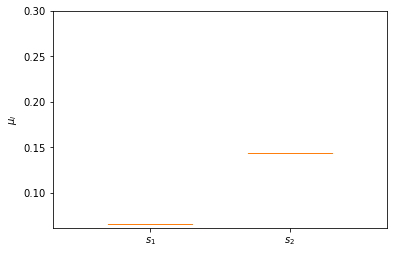

In [41]:
import seaborn as sns
pos = np.array([1, 2])
width = 0.2
box1 = plt.boxplot(np.exp(mu_l_norm[0]+sigma_l_norm[0]/2), positions=pos-width, widths=width, patch_artist=True)
box2 = plt.boxplot(np.exp(mu_l_noc[0]+sigma_l_noc[0]/2), positions=pos, widths=width, patch_artist=True)
box3 = plt.boxplot(np.exp(mu_l_kop[0]+sigma_l_kop[0]/2), positions=pos+width, widths=width, patch_artist=True)
plt.axis(ymax=0.3)
plt.ylabel(r'$\mu_l$')
plt.xticks([1,2], [r'$s_1$', r'$s_2$'])

for p1, p2, p3 in zip(box1['boxes'], box2['boxes'], box3['boxes']):
    p1.set_facecolor('blue')
    p2.set_facecolor('red')
    p3.set_facecolor('green')
    
plt.savefig('mu_l.png')
print(np.median(np.exp(mu_l_norm[0]+sigma_l_norm[0]/2),axis=0))
print(np.median(np.exp(mu_l_noc[0]+sigma_l_noc[0]/2),axis=0))
print(np.median(np.exp(mu_l_kop[0]+sigma_l_kop[0]/2),axis=0))

In [42]:
from scipy.stats import wilcoxon, mannwhitneyu

mean_l_norm = np.exp(mu_l_norm[0]+sigma_l_norm[0]/2)
mean_l_noc = np.exp(mu_l_noc[0]+sigma_l_noc[0]/2)
mean_l_kop = np.exp(mu_l_kop[0]+sigma_l_kop[0]/2)
print(wilcoxon(mean_l_norm[:,0], mean_l_norm[:,1]))
print(wilcoxon(mean_l_noc[:,0], mean_l_noc[:,1]))
print(np.mean(mean_l_noc, axis=0))
print(np.mean(mean_l_norm, axis=0))

WilcoxonResult(statistic=0.0, pvalue=2.381600164396281e-21)
WilcoxonResult(statistic=0.0, pvalue=0.0)
[0.06489401 0.14298722]
[0.06489401 0.14298722]


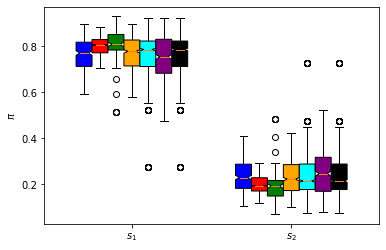

In [43]:
pos = np.array([1, 3])
width = 0.2
box1 = plt.boxplot(pi_norm[8], positions=pos-3*width, widths=width, patch_artist=True, notch=True)
box2 = plt.boxplot(pi_noc[8], positions=pos-2*width, widths=width, patch_artist=True, notch=True)
box3 = plt.boxplot(pi_kop[8], positions=pos-width, widths=width, patch_artist=True, notch=True)
box4 = plt.boxplot(pi_S44A[8], positions=pos, widths=width, patch_artist=True, notch=True)
box5 = plt.boxplot(pi_S44D[8], positions=pos+width, widths=width, patch_artist=True, notch=True)
box6 = plt.boxplot(pi_S44E[8], positions=pos+2*width, widths=width, patch_artist=True, notch=True)
box7 = plt.boxplot(pi_KOP5[8], positions=pos+3*width, widths=width, patch_artist=True, notch=True)

#plt.axis(ymax=0.3)
plt.ylabel(r'$\pi$')
plt.xticks([1,3], [r'$s_1$', r'$s_2$'])

for p1, p2, p3, p4, p5, p6, p7 in zip(box1['boxes'], box2['boxes'], box3['boxes'], box4['boxes'], box5['boxes'], box6['boxes'], box7['boxes']):
    p1.set_facecolor('blue')
    p2.set_facecolor('red')
    p3.set_facecolor('green')
    p4.set_facecolor('orange')
    p5.set_facecolor('cyan')
    p6.set_facecolor('purple')
    p7.set_facecolor('black')

plt.savefig('/home/svensson/Dropbox/Projects/HMM/Figs/pi_10steps.png')

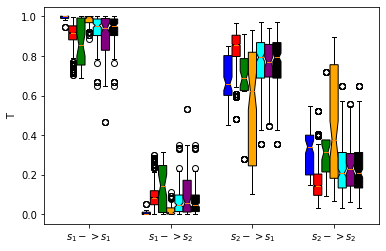

In [44]:
pos = np.array([1, 3, 5, 7])
width = 0.2
box1 = plt.boxplot(T_norm[0].reshape((T_norm[0].shape[0],4)), positions=pos-3*width, widths=width, patch_artist=True, notch=True)
box2 = plt.boxplot(T_noc[0].reshape((T_noc[0].shape[0],4)), positions=pos-2*width, widths=width, patch_artist=True, notch=True)
box3 = plt.boxplot(T_kop[0].reshape((T_kop[0].shape[0],4)), positions=pos-width, widths=width, patch_artist=True, notch=True)
box4 = plt.boxplot(T_S44A[0].reshape((T_S44A[0].shape[0],4)), positions=pos, widths=width, patch_artist=True, notch=True)
box5 = plt.boxplot(T_S44D[0].reshape((T_S44D[0].shape[0],4)), positions=pos+width, widths=width, patch_artist=True, notch=True)
box6 = plt.boxplot(T_S44E[0].reshape((T_S44E[0].shape[0],4)), positions=pos+2*width, widths=width, patch_artist=True, notch=True)
box7 = plt.boxplot(T_KOP5[0].reshape((T_KOP5[0].shape[0],4)), positions=pos+3*width, widths=width, patch_artist=True, notch=True)

#plt.axis(ymax=0.3)
plt.ylabel(r'T')
plt.xticks([1, 3, 5, 7], [r'$s_1->s_1$', r'$s_1->s_2$', r'$s_2->s_1$', r'$s_2->s_2$'])

for p1, p2, p3, p4, p5, p6, p7 in zip(box1['boxes'], box2['boxes'], box3['boxes'], box4['boxes'], box5['boxes'], box6['boxes'], box7['boxes']):
    p1.set_facecolor('blue')
    p2.set_facecolor('red')
    p3.set_facecolor('green')
    p4.set_facecolor('orange')
    p5.set_facecolor('cyan')
    p6.set_facecolor('purple')
    p7.set_facecolor('black')
    
    
plt.savefig('/home/svensson/Dropbox/Projects/HMM/Figs/T_2steps.png')

In [91]:
T = [T_norm, T_noc, T_kop]#, T_S44A, T_S44D, T_S44E, T_KOP5]
step_lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
transitions = np.array([['s1->s1', 's1->s2'], ['s2->s1', 's2->s2']])
cols = ['T', 'number of consecutive steps', 'transition', 'condition']
conditions = ['norm', 'noc', 'KO PEX 14']#, 'S44A', 'S44D', 'S44E', 'KO PEX 5']
sh = T_norm[0].shape[0]
print(T_norm[0].shape)

df = pd.DataFrame(columns=cols, data=np.array([T_norm[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[0]]*sh]).T)
sh = T_noc[0].shape[0]
pd.concat([df, pd.DataFrame(columns=cols, data=np.array([T_noc[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[1]]*sh]).T)])
df = None
for cond, T0 in enumerate(T):
    for steps in range(9):
        for tr1 in range(2):
            for tr2 in range(2):
                sh = T0[steps].shape[0]
                if df is None:
                    df = pd.DataFrame(columns=cols, data=np.array([T0[steps][:,tr1,tr2], [step_lengths[steps]]*sh, [transitions[tr1,tr2]]*sh, [conditions[cond]]*sh]).T)
                else:
                    df = pd.concat([df, pd.DataFrame(columns=cols, data=np.array([T0[steps][:,tr1,tr2], [step_lengths[steps]]*sh, [transitions[tr1,tr2]]*sh, [conditions[cond]]*sh]).T)])
    
df.to_csv('T.csv')

(90, 2, 2)


In [92]:
T = [T_per_cell_norm_all, T_per_cell_noc_all, T_per_cell_kop_all]#, T_per_cell_S44A_all, T_per_cell_S44D_all, T_per_cell_S44E_all, T_per_cell_KOP5_all]
#step_lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
transitions = np.array([['s1->s1', 's1->s2'], ['s2->s1', 's2->s2']])
cols = ['T', 'transition', 'condition']
conditions = ['norm', 'noc', 'KO PEX 14']#, 'S44A', 'S44D', 'S44E', 'KO PEX 5']
#sh = T_norm[0].shape[0]
#print(T_per_cell_KOP5.shape)

#df_per_cell = pd.DataFrame(columns=cols, data=np.array([T_norm[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[0]]*sh]).T)
#sh = T_noc[0].shape[0]
#pd.concat([df, pd.DataFrame(columns=cols, data=np.array([T_noc[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[1]]*sh]).T)])
df_per_cell_all = None
for cond, T0 in enumerate(T):
    print(conditions[cond])
    #print(T0[0,0,tr1,tr2])
    #for steps in range(9):
    sh = T0.shape[0]
    for tr1 in range(2):
        for tr2 in range(2):
            #print(T0[:,tr1,tr2])
            try:           
                if df_per_cell_all is None:
                    df_per_cell_all = pd.DataFrame(columns=cols, data=np.array([T0[:,tr1,tr2], [transitions[tr1,tr2]]*sh, [conditions[cond]]*sh]).T)
                else:
                    df_per_cell_all = pd.concat([df_per_cell_all, pd.DataFrame(columns=cols, data=np.array([T0[:,tr1,tr2], [transitions[tr1,tr2]]*sh, [conditions[cond]]*sh]).T)])
            except:
                continue
df_per_cell_all.to_csv('T_per_cell_all.csv')

norm
noc
KO PEX 14


In [93]:
T = [T_per_cell_norm, T_per_cell_noc, T_per_cell_kop]#, T_per_cell_S44A, T_per_cell_S44D, T_per_cell_S44E, T_per_cell_KOP5]
step_lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
transitions = np.array([['s1->s1', 's1->s2'], ['s2->s1', 's2->s2']])
cols = ['T', 'number of consecutive steps', 'transition', 'condition']
conditions = ['norm', 'noc', 'KO PEX 14']#, 'S44A', 'S44D', 'S44E', 'KO PEX 5']
#sh = T_norm[0].shape[0]
#print(T_per_cell_KOP5.shape)

#df_per_cell = pd.DataFrame(columns=cols, data=np.array([T_norm[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[0]]*sh]).T)
#sh = T_noc[0].shape[0]
#pd.concat([df, pd.DataFrame(columns=cols, data=np.array([T_noc[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[1]]*sh]).T)])
df_per_cell = None
for cond, T0 in enumerate(T):
    print(conditions[cond])
    #print(T0[0,0,tr1,tr2])
    for steps in range(9):
        sh = T0.shape[0]
        for tr1 in range(2):
            for tr2 in range(2):
                #print(T0[:,steps,tr1,tr2])
                try:           
                    if df_per_cell is None:
                        df_per_cell = pd.DataFrame(columns=cols, data=np.array([T0[:,steps,tr1,tr2], [step_lengths[steps]]*sh, [transitions[tr1,tr2]]*sh, [conditions[cond]]*sh]).T)
                    else:
                        df_per_cell = pd.concat([df_per_cell, pd.DataFrame(columns=cols, data=np.array([T0[:,steps,tr1,tr2], [step_lengths[steps]]*sh, [transitions[tr1,tr2]]*sh, [conditions[cond]]*sh]).T)])
                except:
                    continue
df_per_cell.to_csv('T_per_cell.csv')

norm
noc
KO PEX 14


In [94]:
PI = [pi_norm, pi_noc, pi_kop]#, pi_S44A, pi_S44D, pi_S44E, pi_KOP5]
step_lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
states = np.array(['pi_s1', 'pi_s2'])
cols = ['pi', 'number of consecutive steps', 'state', 'condition']
conditions = ['norm', 'noc', 'KO PEX 14']#, 'S44A', 'S44D', 'S44E', 'KO PEX 5']
sh = T_norm[0].shape[0]
print(T_norm[0].shape)

#df = pd.DataFrame(columns=cols, data=np.array([T_norm[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[0]]*sh]).T)
#sh = T_noc[0].shape[0]
#pd.concat([df, pd.DataFrame(columns=cols, data=np.array([T_noc[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[1]]*sh]).T)])
df_pi = None
for cond, pi0 in enumerate(PI):
    for steps in range(9):
        for s in range(2):
            #print(pi0[steps].shape)
            sh = pi0[steps].shape[0]
            if df_pi is None:
                df_pi = pd.DataFrame(columns=cols, data=np.array([pi0[steps][:,s], [step_lengths[steps]]*sh, [states[s]]*sh, [conditions[cond]]*sh]).T)
            else:
                df_pi = pd.concat([df_pi, pd.DataFrame(columns=cols, data=np.array([pi0[steps][:,s], [step_lengths[steps]]*sh, [states[s]]*sh, [conditions[cond]]*sh]).T)])
    
df_pi.to_csv('pi.csv')

(90, 2, 2)


In [96]:
PI = [pi_norm_all, pi_noc_all, pi_kop_all]#, pi_S44A_all, pi_S44D_all, pi_S44E_all, pi_KOP5_all]
step_lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
states = np.array(['pi_s1', 'pi_s2'])
cols = ['pi', 'state', 'condition']
conditions = ['norm', 'noc', 'KO PEX 14']#, 'S44A', 'S44D', 'S44E', 'KO PEX 5']
sh = T_norm[0].shape[0]
#print(PI[3].shape)

#df = pd.DataFrame(columns=cols, data=np.array([T_norm[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[0]]*sh]).T)
#sh = T_noc[0].shape[0]
#pd.concat([df, pd.DataFrame(columns=cols, data=np.array([T_noc[0][:,0,0], [step_lengths[0]]*sh, [transitions[0,0]]*sh, [conditions[1]]*sh]).T)])
df_pi = None
for cond, pi0 in enumerate(PI):
    #for steps in range(9):
    for s in range(2):
        #print(pi0[steps].shape)
        sh = pi0.shape[0]
        if df_pi is None:
            df_pi = pd.DataFrame(columns=cols, data=np.array([pi0[:,s], [states[s]]*sh, [conditions[cond]]*sh]).T)
        else:
            df_pi = pd.concat([df_pi, pd.DataFrame(columns=cols, data=np.array([pi0[:,s], [states[s]]*sh, [conditions[cond]]*sh]).T)])

df_pi.to_csv('pi_all.csv')

In [97]:
df_per_cell["T"] = df_per_cell["T"].astype('float')
df_pi["pi"] = df_pi["pi"].astype('float')
df_per_cell_all["T"] = df_per_cell_all["T"].astype('float')
df["T"] = df["T"].astype('float')

In [98]:
import plotly.express as px

fig = px.box(df_per_cell, x="transition", y="T", color="condition", animation_frame="number of consecutive steps", notched=True)
fig.write_html("T_per_cell.html")

In [99]:
df["T"] = df["T"].astype('float')

In [100]:
fig = px.box(df, x="transition", y="T", color="condition", animation_frame="number of consecutive steps", notched=True)
fig.write_html("T_all.html")

In [101]:
fig = px.box(df_per_cell_all, x="transition", y="T", color="condition", notched=True)
fig.write_html("T_per_cell_all.html")

In [102]:
fig = px.box(df_pi, x="state", y="pi", color="condition", notched=True)
fig.write_html("PI_all_per_cell.html")

In [103]:
fig = px.box(df_per_cell, x="transition", y="T", color="condition", animation_frame="number of consecutive steps", notched=True)
fig.write_html("T_per_cell.html")

In [104]:
print('noc->kop, s2->s2')
print(mannwhitneyu(T_noc[8][:,1,1], T_kop[8][:,1,1]))
print('noc->norm, s2->s2')
print(mannwhitneyu(T_noc[8][:,1,1], T_norm[8][:,1,1]))
print('kop->norm, s2->s2')
print(mannwhitneyu(T_norm[8][:,1,1], T_kop[8][:,1,1]))

noc->kop, s2->s2
MannwhitneyuResult(statistic=74677.0, pvalue=9.575414834424604e-19)
noc->norm, s2->s2
MannwhitneyuResult(statistic=228491.0, pvalue=3.3964393160701644e-43)
kop->norm, s2->s2
MannwhitneyuResult(statistic=12962.0, pvalue=0.031557040810744806)


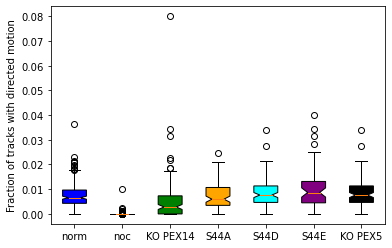

In [105]:
box1 = plt.boxplot([PS_norm[:,8], PS_noc[:,8], PS_kop[:,8], PS_S44A[:,8], PS_S44D[:,8],PS_S44E[:,8], PS_KOP5[:,8]], patch_artist=True, notch=True)

colors = ['blue', 'red', 'green', 'orange', 'cyan', 'purple', 'black']
for p1, c in zip(box1['boxes'], colors):
    p1.set_facecolor(c)
    
plt.ylabel('Fraction of tracks with directed motion')
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['norm', 'noc', 'KO PEX14', 'S44A', 'S44D', 'S44E', 'KO PEX5'])
plt.savefig('Fraction_10steps.png')

In [106]:
print('noc->kop')
print(mannwhitneyu(PS_noc[:,6], PS_kop[:,6]))
print('noc->norm')
print(mannwhitneyu(PS_noc[:,6], PS_norm[:,6]))
print('kop->norm')
print(mannwhitneyu(PS_kop[:,6], PS_norm[:,6]))

noc->kop
MannwhitneyuResult(statistic=3340.5, pvalue=2.517593174321635e-18)
noc->norm
MannwhitneyuResult(statistic=297.5, pvalue=2.535756013865372e-50)
kop->norm
MannwhitneyuResult(statistic=6582.5, pvalue=3.576476428374853e-13)


In [107]:
PS_norm.shape

(190, 9)

In [108]:
import matplotlib

In [109]:
@jit(nopython=True)
def boostrap_CI(P, CI=95, N=1000):
    m = np.zeros(P.shape[1])#.astype(np.float)#p.mean(P, axis=0)
    mean_upper_CI = np.zeros(P.shape[1])#.astype(np.float)
    mean_lower_CI = np.zeros(P.shape[1])#.astype(np.float)
    for ii in range(P.shape[1]):
        CI_dist = np.zeros(N)#.astype(np.float)
        for n in range(N):
            N_samp = np.random.randint(1, P.shape[0])
            samp_idx = np.random.randint(0, P.shape[0], N_samp)
            CI_dist[n] = np.median(P[samp_idx,ii])
        mean_upper_CI[ii] = np.percentile(CI_dist, CI+(100-CI)/2)
        mean_lower_CI[ii] = np.percentile(CI_dist, (100-CI)/2)
        m[ii] = np.median(P[:,ii])
        
    return m, mean_upper_CI, mean_lower_CI

In [110]:
m, mu, ml = boostrap_CI(PS_norm)
print(m)
print(mu)

[0.24067896 0.12314954 0.06410542 0.03755774 0.02278592 0.01554947
 0.0114045  0.00867723 0.00656815]
[0.30209921 0.15179992 0.07774587 0.0422599  0.02635102 0.01854316
 0.01417798 0.01042615 0.00819679]


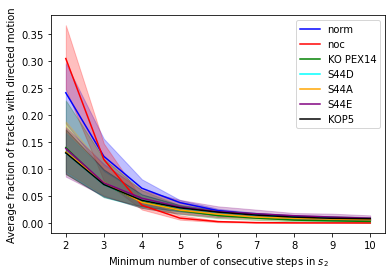

In [111]:
m_norm, upper_norm, lower_norm = boostrap_CI(PS_norm)
m_noc, upper_noc, lower_noc = boostrap_CI(PS_noc)
m_kop, upper_kop, lower_kop = boostrap_CI(PS_kop)
m_S44A, upper_S44A, lower_S44A = boostrap_CI(PS_S44A)
m_S44D, upper_S44D, lower_S44D = boostrap_CI(PS_S44D)
m_S44E, upper_S44E, lower_S44E = boostrap_CI(PS_S44E)
m_KOP5, upper_KOP5, lower_KOP5 = boostrap_CI(PS_KOP5)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(range(2,11), m_norm, label = 'norm', color = 'blue')
plt.plot(range(2,11), m_noc, label = 'noc', color = 'red')
plt.plot(range(2,11), m_kop, label = 'KO PEX14', color = 'green')
plt.plot(range(2,11), m_S44D, label = 'S44D', color = 'cyan')
plt.plot(range(2,11), m_S44A, label = 'S44A', color = 'orange')
plt.plot(range(2,11), m_S44E, label = 'S44E', color = 'purple')
plt.plot(range(2,11), m_KOP5, label = 'KOP5', color = 'black')
plt.fill_between(range(2,11), lower_norm, upper_norm, color='blue', alpha=0.25)
plt.fill_between(range(2,11), lower_noc, upper_noc, color='red', alpha=0.25)
plt.fill_between(range(2,11), lower_kop, upper_kop, color='green', alpha=0.25)
plt.fill_between(range(2,11), lower_S44A, upper_S44A, color='orange', alpha=0.25)
plt.fill_between(range(2,11), lower_S44D, upper_S44D, color='cyan', alpha=0.25)
plt.fill_between(range(2,11), lower_S44E, upper_S44E, color='purple', alpha=0.25)
plt.fill_between(range(2,11), lower_KOP5, upper_KOP5, color='black', alpha=0.25)
ax.set_yscale('linear')
plt.legend()
plt.ylabel('Average fraction of tracks with directed motion')
plt.xlabel('Minimum number of consecutive steps in $s_2$')
plt.savefig('frac straight tracks.png')

In [119]:
import plotly.graph_objects as go
x = [2,3,4,5,6,7,8,9,10]
data = pd.DataFrame(np.array([m_norm, m_noc, m_kop, m_S44A, m_S44D, m_S44E, m_KOP5]).T, columns=["norm", "noc", "KO PEX 14", 'S44A', 'S44D', 'S44E', 'KO PEX 5']).reset_index()
lower = pd.DataFrame(np.array([lower_norm, lower_noc, lower_kop, lower_S44A, lower_S44D, lower_S44E, lower_KOP5]).T, columns=["norm", "noc", "KO PEX 14", 'S44A', 'S44D', 'S44E', 'KO PEX 5']).reset_index()
upper = pd.DataFrame(np.array([upper_norm, upper_noc, upper_kop, upper_S44A, upper_S44D, upper_S44E, upper_KOP5]).T, columns=["norm", "noc", "KO PEX 14", 'S44A', 'S44D', 'S44E', 'KO PEX 5']).reset_index()


fig = go.Figure([
    go.Scatter(
        x=x,
        y=m_norm,
        line=dict(color='rgb(0,0,200)'),
        mode='lines',
        legendgroup="norm",
        name="norm"
    ),
    go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_norm)+list(upper_norm)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,0,200,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="norm",
        showlegend=False
    )
])
fig.add_trace(go.Scatter(
        x=x,
        y=m_noc,
        line=dict(color='rgb(200,0,0)'),
        mode='lines',
        legendgroup="noc",
        name="noc"
    ))
fig.add_trace(go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_noc)+list(upper_noc)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(200,0,0,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="noc",
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        x=x,
        y=m_kop,
        line=dict(color='rgb(200,0,200)'),
        mode='lines',
        legendgroup="kop14",
        name="KO-PEX 14"
    ))
fig.add_trace(go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_kop)+list(upper_kop)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(200,0,200,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="kop14",
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        x=x,
        y=m_S44A,
        line=dict(color='rgb(80,0,100)'),
        mode='lines',
        legendgroup="S44A",
        name="S44A"
    ))
fig.add_trace(go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_S44A)+list(upper_S44A)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(80,0,100,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="S44A",
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        x=x,
        y=m_S44D,
        line=dict(color='rgb(80,100,0)'),
        mode='lines',
        legendgroup="S44D",
        name="S44D"
    ))
fig.add_trace(go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_S44D)+list(upper_S44D)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(80,100,0,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="S44D",
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        x=x,
        y=m_S44E,
        line=dict(color='rgb(150,70,0)'),
        mode='lines',
        legendgroup="S44E",
        name="S44E"
    ))
fig.add_trace(go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_S44E)+list(upper_S44E)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(150,70,0,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="S44E",
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        x=x,
        y=m_KOP5,
        line=dict(color='rgb(0,0,0)'),
        mode='lines',
        legendgroup="kop5",
        name="KO-PEX 5"
    ))
fig.add_trace(go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_KOP5)+list(upper_KOP5)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,0,0,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="kop5",
        showlegend=False
    ))
fig.update_xaxes(title=r'Minimum number of consecutive steps in $s_2$')
fig.update_yaxes(title='Average fraction of tracks with directed motion')
fig.write_html("test.html")

In [120]:
import plotly.graph_objects as go
x = [2,3,4,5,6,7,8,9,10]
data = pd.DataFrame(np.array([m_norm, m_noc, m_kop]).T, columns=["norm", "noc", "KO PEX 14"]).reset_index()
lower = pd.DataFrame(np.array([lower_norm, lower_noc, lower_kop]).T, columns=["norm", "noc", "KO PEX 14"]).reset_index()
upper = pd.DataFrame(np.array([upper_norm, upper_noc, upper_kop]).T, columns=["norm", "noc", "KO PEX 14"]).reset_index()


fig = go.Figure([
    go.Scatter(
        x=x,
        y=m_norm,
        line=dict(color='rgb(0,0,200)'),
        mode='lines',
        legendgroup="norm",
        name="norm"
    ),
    go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_norm)+list(upper_norm)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,0,200,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="norm",
        showlegend=False
    )
])
fig.add_trace(go.Scatter(
        x=x,
        y=m_noc,
        line=dict(color='rgb(200,0,0)'),
        mode='lines',
        legendgroup="noc",
        name="noc"
    ))
fig.add_trace(go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_noc)+list(upper_noc)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(200,0,0,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="noc",
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        x=x,
        y=m_kop,
        line=dict(color='rgb(200,0,200)'),
        mode='lines',
        legendgroup="kop14",
        name="KO-PEX 14"
    ))
fig.add_trace(go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=list(lower_kop)+list(upper_kop)[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(200,0,200,0.2)',
        line=dict(color='rgba(255,255,0,0.0)'),
        hoverinfo="skip",
        legendgroup="kop14",
        showlegend=False
    ))
fig.update_xaxes(title=r'Minimum number of consecutive steps in $s_2$')
fig.update_yaxes(title='Average fraction of tracks with directed motion')
fig.write_html("Ratio_of_S2_tracks.html")

Text(0.5, 0, 'Minimum number of consecutive steps in $s_1$')

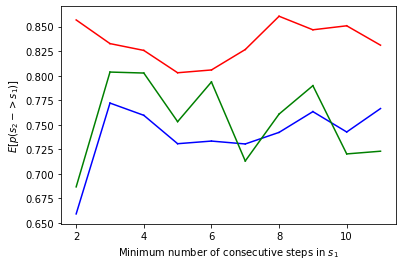

In [113]:
for st in range(9):
    plt.plot([st+2, st+3], [np.median(T_norm[st], axis=0)[1,0], np.median(T_norm[st+1], axis=0)[1,0]], label = 'norm', color = 'blue')
    plt.plot([st+2, st+3], [np.median(T_noc[st], axis=0)[1,0], np.median(T_noc[st+1], axis=0)[1,0]], label = 'norm', color = 'red')
    plt.plot([st+2, st+3], [np.median(T_kop[st], axis=0)[1,0], np.median(T_kop[st+1], axis=0)[1,0]], label = 'norm', color = 'green')
#plt.plot(range(2,11), np.mean(PS_noc, axis=0), label = 'noc', color = 'red')
#plt.plot(range(2,11), np.mean(PS_kop, axis=0), label = 'KO PEX', color = 'green')
#plt.legend()
plt.ylabel(r'$E[p(s_2->s_1)]$')
plt.xlabel('Minimum number of consecutive steps in $s_1$')

In [152]:
def track_statistics_per_state(tables, norm=False, new_data=False):
    mu_s1 = []
    mu_s2 = []
    for table in tqdm(tables[:]):
        #print(table)
        d = table[:]
        #if Path(d+"/Tracks").exists():
        #    fileList = glob.glob(d+"/Tracks/*.png", recursive=False)
        #    for im in fileList:
        #        os.remove(im)
        #Path(d+"/Tracks").mkdir(parents=True, exist_ok=True)
        #print(d)
        key_counter = 0
        #tracks = pd.read_csv(d + 'Track_Data.xls', sep='\t')
        if norm:
            try:
                if len(glob.glob(d + '/*.xls'))>0:
                    tracks = pd.read_csv(d + '/' + d[d.rfind('/')+1:] + '.xls', sep='\t')
                elif len(glob.glob(d + '/*.xlsx'))>0: 
                    tracks = pd.read_csv(d + '/' + d[d.rfind('/')+1:] + '.xlsx', sep='\t')
                else:
                    tracks = pd.read_csv(d + '/' + d[d.rfind('/')+1:] + '.csv', sep=',')
                with open(d + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
                    params = json.load(read_file)

            except:
                print('Could not read params and/or track file for %s'%d)
                continue
        elif new_data:
            try:
                track_file = d + d[d.rfind('/'):]+'.xls'
                tracks = pd.read_csv(track_file, sep='\t')
                with open(d + '/' +"fitted_params_mu_sig_fixed2.json", "r") as read_file:
                    params = json.load(read_file)
            except:
                print('Could not read params and/or track file for %s'%track_file)
                continue
        else:   
            try:
                tracks = pd.read_csv(d + '/Track_Data.xls', sep='\t')
                with open(d + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
                    params = json.load(read_file)
            except:
                print('Could not read params and/or track file for %s'%d)
                continue
            try:
                with open(d + "/fitted_params_mu_sig_fixed2.json", "r") as read_file:
                    params = json.load(read_file)
            except:
                continue
        mu_s1_tmp = []        
        mu_s2_tmp = []        
        for key in params.keys(): 
            track = int(params[key]['track_id'])
            track0 = tracks.loc[tracks['TRACK_ID']==track]                
        
            pi_tot = np.array(params[key]['pi'])
            mu_tot = np.array(params[key]['mu_l'])
            sigma_tot = np.array(params[key]['sigma_l'])
            T_tot = np.array(params[key]['T'])
            
            X = np.array([track0['POSITION_X'], track0['POSITION_Y']]).T
            l, alpha = convert_to_planar(X)
            o = np.array([l[1:-1], alpha]).T
            if o.shape[0] > 50 and np.isfinite(T_tot).all() and np.isfinite(pi_tot).all() and np.isfinite(mu_tot).all() and np.isfinite(sigma_tot).all():
                s_est, D, E = viterbi(T_tot, pi_tot, mu_tot, sigma_tot, float(params['0']['sigma_alpha_2']), o)
                s1_idx = (s_est==0).nonzero()[0]
                s2_idx = s_est.nonzero()[0]
                if s1_idx.shape[0]>0:
                    #print(o[s2_idx,0])
                    [mu_s1_tmp.append(l0) for l0 in o[s1_idx,0]]
                if s2_idx.shape[0]>0:
                    #print(o[s2_idx,0])
                    [mu_s2_tmp.append(l0) for l0 in o[s2_idx,0]]
        if len(mu_s1_tmp)>0:        
            mu_s1.append(np.mean(mu_s1_tmp))
        if len(mu_s2_tmp)>0:        
            mu_s2.append(np.mean(mu_s2_tmp))
    return mu_s1, mu_s2        
            

In [155]:
with open('/data/Peroxisome tracks/HEK WT/cell_list.txt') as f_norm:
    norm_tables = f_norm.read().splitlines()

mu_s1_norm, mu_s2_norm = track_statistics_per_state(norm_tables, norm=True)


 69%|██████▉   | 134/194 [06:05<02:18,  2.31s/it]

Could not read params and/or track file for /data/Peroxisome tracks/HEK WT/20180427_HEK293_pJK26_GFP90ms_Triggered_5-cell2


 73%|███████▎  | 141/194 [06:24<02:03,  2.34s/it]

Could not read params and/or track file for /data/Peroxisome tracks/HEK WT/20180427_HEK293_pJK26_GFP90ms_Triggered_5-cell4


 77%|███████▋  | 150/194 [06:46<01:26,  1.96s/it]

Could not read params and/or track file for /data/Peroxisome tracks/HEK WT/20180802_HEK _pJK26_GFP90ms_Triggered_2_1 cell1


 97%|█████████▋| 189/194 [08:10<00:11,  2.25s/it]

Could not read params and/or track file for /data/Peroxisome tracks/HEK WT/20180427_HEK293_pJK26_GFP90ms_Triggered_5-cell3


100%|██████████| 194/194 [08:21<00:00,  2.58s/it]


In [151]:
mu_s2

[0.17693667917611522, 0.15650724859264922]

In [154]:
mu_s1

[0.03708081588174141, 0.06294149642131934]

In [156]:
with open('/data/Peroxisome tracks/noc/cell_list.txt') as f_norm:
    noc_tables = f_norm.read().splitlines()

mu_s1_noc, mu_s2_noc = track_statistics_per_state(noc_tables)

100%|██████████| 130/130 [26:21<00:00, 12.17s/it]


In [157]:
with open('/data/Peroxisome tracks/ko pex14/cell_list.txt') as f_norm:
    kop_tables = f_norm.read().splitlines()
    
mu_s1_kop, mu_s2_kop = track_statistics_per_state(kop_tables)

  2%|▏         | 3/134 [00:01<01:04,  2.02it/s]

Could not read params and/or track file for /data/Peroxisome tracks/ko pex14/20180621_HEK KO PEX14_pJK26_GFP90ms_Triggered_2_5 cell3.csv_Ordner


 51%|█████▏    | 69/134 [00:42<00:28,  2.31it/s]

Could not read params and/or track file for /data/Peroxisome tracks/ko pex14/20180427_KOPX14_pJK26_GFP90ms_Triggered_2_4cell3.xls_Ordner


 71%|███████   | 95/134 [01:02<00:28,  1.35it/s]

Could not read params and/or track file for /data/Peroxisome tracks/ko pex14/20180427_KOPEX14_pJK26_GFP90ms_Triggered_1_2.cell2.xls_Ordner


100%|██████████| 134/134 [01:28<00:00,  1.51it/s]


In [161]:
cols = ["mu_s1_norm", "mu_s2_norm", "mu_s1_noc", "mu_s2_noc", "mu_s1_kop", "mu_s2_kop"]
data = [mu_s1_norm, mu_s2_norm, mu_s1_noc, mu_s2_noc, mu_s1_kop, mu_s2_kop].T
df = pd.DataFrame(data, columns=cols).reset_index()

AttributeError: 'list' object has no attribute 'T'